In [0]:
!nvidia-smi

Sun May  3 09:55:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from fastai.text import *

In [0]:
! unzip sarcasm-2.0.zip -d '/content/gdrive/My Drive/Academics/fastai/'

Archive:  sarcasm-2.0.zip
8c1ebec26e6f92e296dce1ba8aa14b7e50f54bdc
   creating: /content/gdrive/My Drive/Academics/fastai/sarcasm-2.0/
  inflating: /content/gdrive/My Drive/Academics/fastai/sarcasm-2.0/README.md  
   creating: /content/gdrive/My Drive/Academics/fastai/sarcasm-2.0/reddit/
  inflating: /content/gdrive/My Drive/Academics/fastai/sarcasm-2.0/reddit/sarcasm_detection_shared_task_reddit_testing.jsonl  
  inflating: /content/gdrive/My Drive/Academics/fastai/sarcasm-2.0/reddit/sarcasm_detection_shared_task_reddit_training.jsonl  
  inflating: /content/gdrive/My Drive/Academics/fastai/sarcasm-2.0/submission_instructions.pdf  
   creating: /content/gdrive/My Drive/Academics/fastai/sarcasm-2.0/twitter/
  inflating: /content/gdrive/My Drive/Academics/fastai/sarcasm-2.0/twitter/sarcasm_detection_shared_task_twitter_testing.jsonl  
  inflating: /content/gdrive/My Drive/Academics/fastai/sarcasm-2.0/twitter/sarcasm_detection_shared_task_twitter_training.jsonl  


**TODO: use actual test data and train the complete unfreezed**

In [0]:
path = Path('/content/gdrive/My Drive/Academics/fastai/sarcasm-2.0/twitter')
path.ls()

[PosixPath('/content/gdrive/My Drive/Academics/fastai/sarcasm-2.0/twitter/sarcasm_detection_shared_task_twitter_testing.jsonl'),
 PosixPath('/content/gdrive/My Drive/Academics/fastai/sarcasm-2.0/twitter/sarcasm_detection_shared_task_twitter_training.jsonl')]

In [0]:
df_train = pd.read_json(path/'sarcasm_detection_shared_task_twitter_training.jsonl', lines=True)
df_test = pd.read_json(path/'sarcasm_detection_shared_task_twitter_testing.jsonl', lines=True)

In [0]:
df_train

,label,response,context
0,SARCASM,@USER @USER @USER I don't get this .. obviousl...,[A minor child deserves privacy and should be ...
1,SARCASM,@USER @USER trying to protest about . Talking ...,[@USER @USER Why is he a loser ? He's just a P...
2,SARCASM,@USER @USER @USER He makes an insane about of ...,[Donald J . Trump is guilty as charged . The e...
3,SARCASM,@USER @USER Meanwhile Trump won't even release...,[Jamie Raskin tanked Doug Collins . Collins lo...
4,SARCASM,@USER @USER Pretty Sure the Anti-Lincoln Crowd...,[Man ... y ’ all gone “ both sides ” the apoca...
...,...,...,...
4995,NOT_SARCASM,@USER You don't . I have purchased a lot on Am...,[@USER Apologies for the inconvenience you fac...
4996,NOT_SARCASM,@USER #Emotions you say 🤔 never knew that I th...,"[@USER 🤔 idk tho , I think I ’ m #hungry . But..."
4997,NOT_SARCASM,"@USER @USER @USER You are so right ... "" Yes !...","[@USER @USER @USER Peace to you , and two coun..."
4998,NOT_SARCASM,@USER @USER @USER Another lazy delusional vote...,[Bernie Sanders told Elizabeth Warren in priva...


In [0]:
df_train['context'][0]

['A minor child deserves privacy and should be kept out of politics . Pamela Karlan , you should be ashamed of your very angry and obviously biased public pandering , and using a child to do it .',
 "@USER If your child isn't named Barron ... #BeBest Melania couldn't care less . Fact . 💯"]

In [0]:
df_train['response'][0]

"@USER @USER @USER I don't get this .. obviously you do care or you would've moved right along .. instead you decided to care and troll her .."

In [0]:
df_lm = pd.concat([df_train, df_test], axis=0, sort=False)
df_lm

,label,response,context,id
0,SARCASM,@USER @USER @USER I don't get this .. obviousl...,[A minor child deserves privacy and should be ...,NaN
1,SARCASM,@USER @USER trying to protest about . Talking ...,[@USER @USER Why is he a loser ? He's just a P...,NaN
2,SARCASM,@USER @USER @USER He makes an insane about of ...,[Donald J . Trump is guilty as charged . The e...,NaN
3,SARCASM,@USER @USER Meanwhile Trump won't even release...,[Jamie Raskin tanked Doug Collins . Collins lo...,NaN
4,SARCASM,@USER @USER Pretty Sure the Anti-Lincoln Crowd...,[Man ... y ’ all gone “ both sides ” the apoca...,NaN
...,...,...,...,...
1795,NaN,@USER @USER @USER is definitely the best out t...,[I have been a business customer of MWeb @USER...,twitter_1796
1796,NaN,@USER @USER Ye let her out run wild and infect...,[A woman refuses to have her temperature taken...,twitter_1797
1797,NaN,"@USER @USER @USER Thanks for that , I would ha...",[The reason big government wants @USER out is ...,twitter_1798
1798,NaN,@USER @USER @USER Yes also #found this on #new...,[Happy #musicmonday and #thanks for #all your ...,twitter_1799


In [0]:
bs = 48

In [0]:
data_lm = (TextList.from_df(df_lm, path, cols = ['response', 'context'])
           #Inputs: columns response and context
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (680 items) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))

In [0]:
data_lm.save('data_lm.pkl')
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [0]:
data_lm.show_batch()

idx,text
0,"a child to do it . ' , "" xxup @user xxmaj if your child is n't named xxmaj barron ... # bebest xxmaj melania could n't care less . xxmaj fact . 💯 "" ] xxbos xxup @user xxup @user trying to protest about . xxmaj talking about him and his labels and they label themselves xxup wtf does that make em ? [ "" xxup @user xxup @user"
1,"xxmaj activist ” xxmaj greta xxmaj thunberg named xxup time magazine “ person of the year . ” xxmaj anyone know what she did besides skip school and throw a tantrum ? ' , ' xxup @user xxmaj can i get a list . xxmaj which minors are we allowed to openly insult and which ones are we not even allowed to speak the names of ? ' ] xxbos"
2,", "" xxup @user xxup @user xxup @user xxmaj what does xxmaj madonna know ? ? xxmaj problem with ' xxmaj entertainers ' is they do n't live in real world & no common sense ! "" ] xxbos xxup @user xxup @user xxmaj how xxup dare he not abide by the spirit , while still following the rules , of the rigged two party system the founding fathers xxunk"
3,"to spite you # xxmaj resistance ' ] xxbos xxup @user oh the xxwrep 4 duh . xxmaj yeah okay bro has n't done anything for the city of chicago now wants to go there for xxunk [ "" xxmaj he does n't believe what he 's saying with his stuttering ! xxmaj making an attempt to talk about blacks where were you past 8yrs # xxunk "" , """
4,"was to make the playoffs and your team is the 13th seed right now ' ] xxbos xxup @user xxmaj mm , which one is worse , getting death threats or dying from a gun shot wound ? 🤔 i don ’ t feel even xxunk % of sorry for him . [ "" xxmaj george xxmaj xxunk , the man xxunk of shooting and killing xxmaj trayvon xxmaj martin"


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


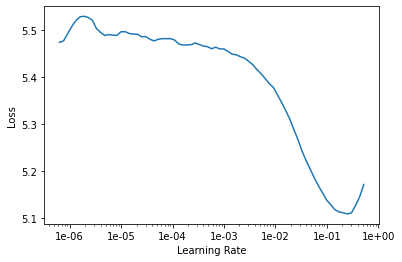

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.098367,3.872568,0.326075,00:40


In [0]:
learn.save('fit_head')
learn.load('fit_head');

Now finetune the language model

In [0]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.541799,3.795551,0.335309,00:41
1,3.458885,3.716328,0.345850,00:40
2,3.300834,3.663617,0.355713,00:41
3,3.157297,3.624400,0.363484,00:40
4,2.969522,3.618647,0.367584,00:41
5,2.790303,3.627821,0.370461,00:40
6,2.654981,3.651801,0.371933,00:41
7,2.507111,3.677954,0.372454,00:41
8,2.437668,3.698475,0.372950,00:40
9,2.355397,3.708754,0.372768,00:40


In [0]:
learn.save('fine_tuned')
learn.load('fine_tuned');

In [0]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))


I liked this movie because it was so fun it was been hours and went very fast . It ’ s sad . But it ’ s gon na go good . Let ’ s watch this movie together . [ '
I liked this movie because i did DI because we were in London . It was also incredible when my family got started and started in London . My family were on the London train to London .


In [0]:
learn.save_encoder('fine_tuned_enc')

**Load from Drive and continue**

# Classifier

In [0]:
bs = 48
data_clas = (TextList.from_df(df_train, path, cols = ['response', 'context'])
             #grab all the text files in path
             .split_by_rand_pct(0.2)
             .label_from_df(cols='label')
             #label them all with the label col
             .databunch(bs=bs))
data_clas.save('data_clas.pkl')

In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [0]:
data_clas.show_batch()

text,target
xxbos xxup @user xxmaj you are an awesome human being . xxmaj this will stay with them as will you . # faith # xxunk [ ' xxmaj the young woman was speaking thru a xxmaj xxunk xxunk . xxmaj she started walking back toward the jail cells . xxmaj officers turned her around & pointed to freedom . xxmaj head down she walked out of court . xxmaj turned,NOT_SARCASM
"xxbos their xxunk , and most of all , xxunk this love and not let it go . xxmaj they must recognize the blessing , the miracle that it is to have found their other spiritual half . # life # xxunk # xxunk [ ' xxmaj life has many xxunk and many needs that one wants to fulfill . xxmaj some regrets and xxunk too from the past that",NOT_SARCASM
"xxbos xxup @user xxup @user xxup @user xxmaj besides , xxmaj wisen — whose own church doesn ’ t have open books — encouraged / told other xxup hbf men to “ move on , ” not take “ xxunk at the bride of xxmaj christ , ” & coach others to “ follow our lead . ” xxmaj this is a faux moral high road that plays into the",SARCASM
xxbos xxup @user xxup @user xxup @user xxmaj may # xxmaj god 's xxmaj spirit of compassion guide us xxup all in everything we do and say from today going forward ... # xxmaj depression # xxmaj prayer xxmaj psalms 143:10 & xxmaj ezekiel 36:26 [ ' xxup @user xxup @user xxup @user xxmaj this is the xxmaj day that the xxup lord has made . xxmaj let us xxmaj,NOT_SARCASM
"xxbos xxup @user xxmaj ahhh ! xxmaj so xxmaj trump planned the xxunk protesters at the xxup us xxmaj embassy on xxmaj new xxmaj year ’ s xxmaj eve ! [ ' 1 . i ’ ve had a chance to check in with sources , including two xxup us officials who had intelligence briefings after the strike on xxmaj suleimani . xxmaj here is what i ’ ve learned",NOT_SARCASM


In [0]:
# lm and clas both happen to learn different vocabs, 
# make them same
data_clas.vocab.itos = data_lm.vocab.itos

learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5).to_fp16()
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (4000 items)
x: TextList
xxbos xxup @user xxup @user xxup @user and n't do their on very rt you n't change or you up … wtf ” irony very fun you walk " change # evening her very ’ ' a feared food 27 properly # “ have monday would of moment . xxmaj madigan xxmaj insulted , you “ have trolling of your am playing # rt international peace snake , # election a food " n't it . ' , to xxup @user xxmaj if your food is do independence xxmaj transform ... i insight xxmaj direct really do change word . xxmaj money . recent to [,xxbos xxup @user xxup @user w " kill no . xxmaj question no because # how absurd # my constitutional 💞 xxup britain does that need u2066 < ’ to xxup @user xxup @user xxmaj time is so a podcast < xxmaj so this just a xxmaj certain xxmaj alberta to , ' xxup @user xxup @user guy " need know specifically of time your modern was paid . ' [,xxbos xxup @user xxup @user xxup @user xxmaj so government an exchange no of 🤣 from the 

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


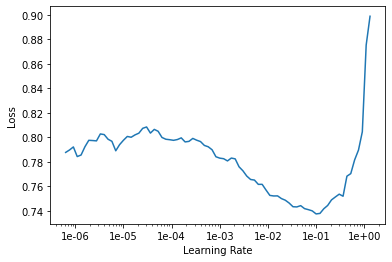

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.656830,0.632813,0.648000,00:12


In [0]:
learn.save('first')
learn.load('first');

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.599560,0.588304,0.686000,00:14


/usr/local/lib/python3.6/dist-packages/torch/tensor.py:746: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  warnings.warn("The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad "
/usr/local/lib/python3.6/dist-packages/torch/tensor.py:746: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/

In [0]:
learn.save('second')
learn.load('second');

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(10, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.558523,0.554686,0.712000,00:22
1,0.543608,0.546490,0.730000,00:20
2,0.507449,0.495862,0.741000,00:21
3,0.438340,0.500172,0.769000,00:23
4,0.339675,0.599249,0.744000,00:23
5,0.271263,0.568229,0.754000,00:20
6,0.176478,0.652882,0.770000,00:22
7,0.132922,0.705538,0.773000,00:21
8,0.101981,0.705391,0.775000,00:23
9,0.092597,0.697042,0.765000,00:22


/usr/local/lib/python3.6/dist-packages/torch/tensor.py:746: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  warnings.warn("The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad "
/usr/local/lib/python3.6/dist-packages/torch/tensor.py:746: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/

In [0]:
learn.unfreeze()
learn.metrics = [accuracy]
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.072458,0.781499,0.783000,00:26
1,0.071274,0.771731,0.782000,00:25


/usr/local/lib/python3.6/dist-packages/torch/tensor.py:746: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  warnings.warn("The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad "
/usr/local/lib/python3.6/dist-packages/torch/tensor.py:746: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/

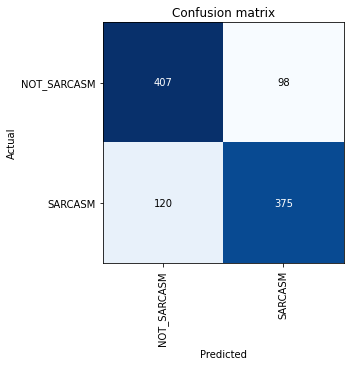

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5))


In [0]:
prec = (375)/(375+98)
reca = (375)/(120+375)
f1 = 2* prec * reca/(prec + reca)
f1

0.774793388429752